In [26]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [27]:
data=pd.read_csv("traffic.csv")
data.head(5)

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


<h1>Data Exploration</h1>

In [28]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
data=data.drop(['ID'] , axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

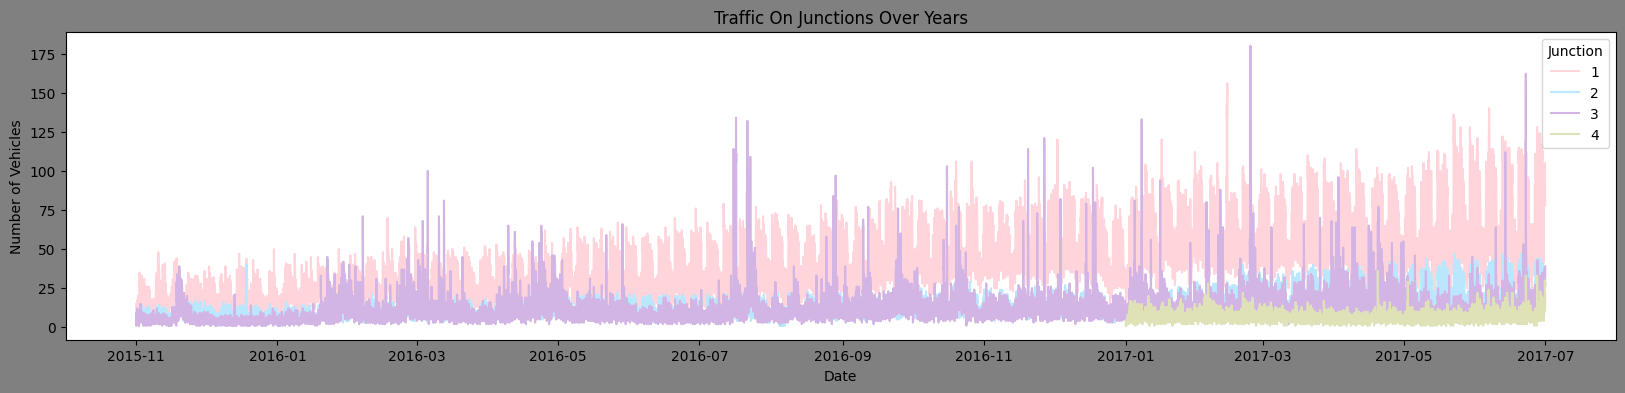

In [29]:
df = data.copy()

#Let's plot the Timeseries
colors=[ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]

plt.figure(figsize=(20,4), facecolor="#808080" )
Time_series=sns.lineplot(x=df['DateTime'],y='Vehicles',data=df,hue="Junction",palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

It can be seen here that the first junction is visibly having an upward trend.
The data for the fourth junction is sparse starting only after 2017
Seasonality is not evident from the above plot, So we must explore datetime composition to figure out more about it.

<h1>Feature Engineering</h1>

In [30]:
#Exploring more features 
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


<h1>Exploratory Data Analysis</h1>

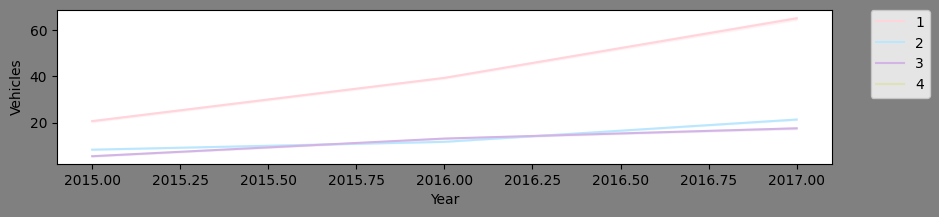

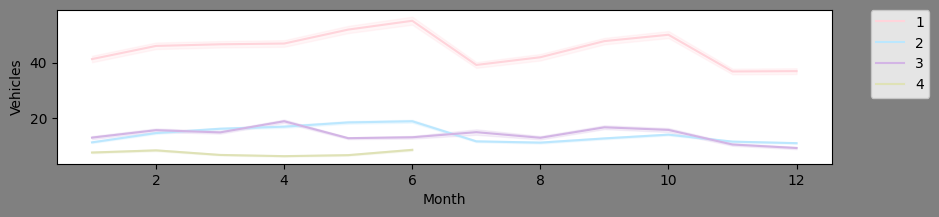

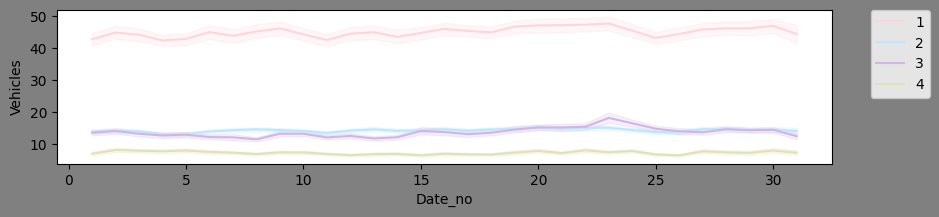

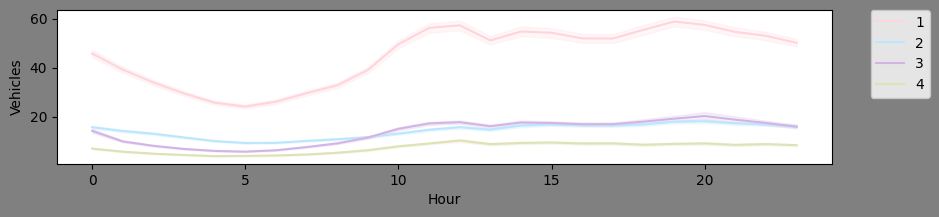

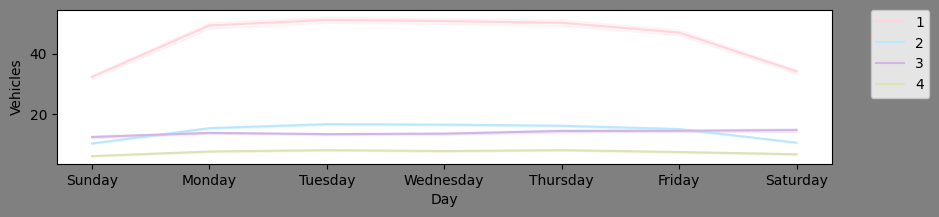

In [31]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor='#808080')
    ax=sns.lineplot(x=df[i],y='Vehicles',data=df,hue='Junction',palette=colors)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0.5, 0, 'Date')

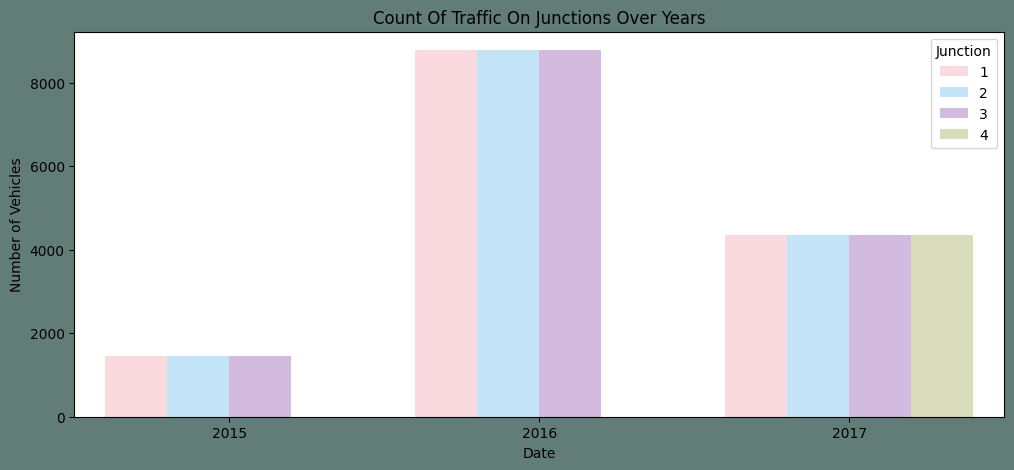

In [32]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

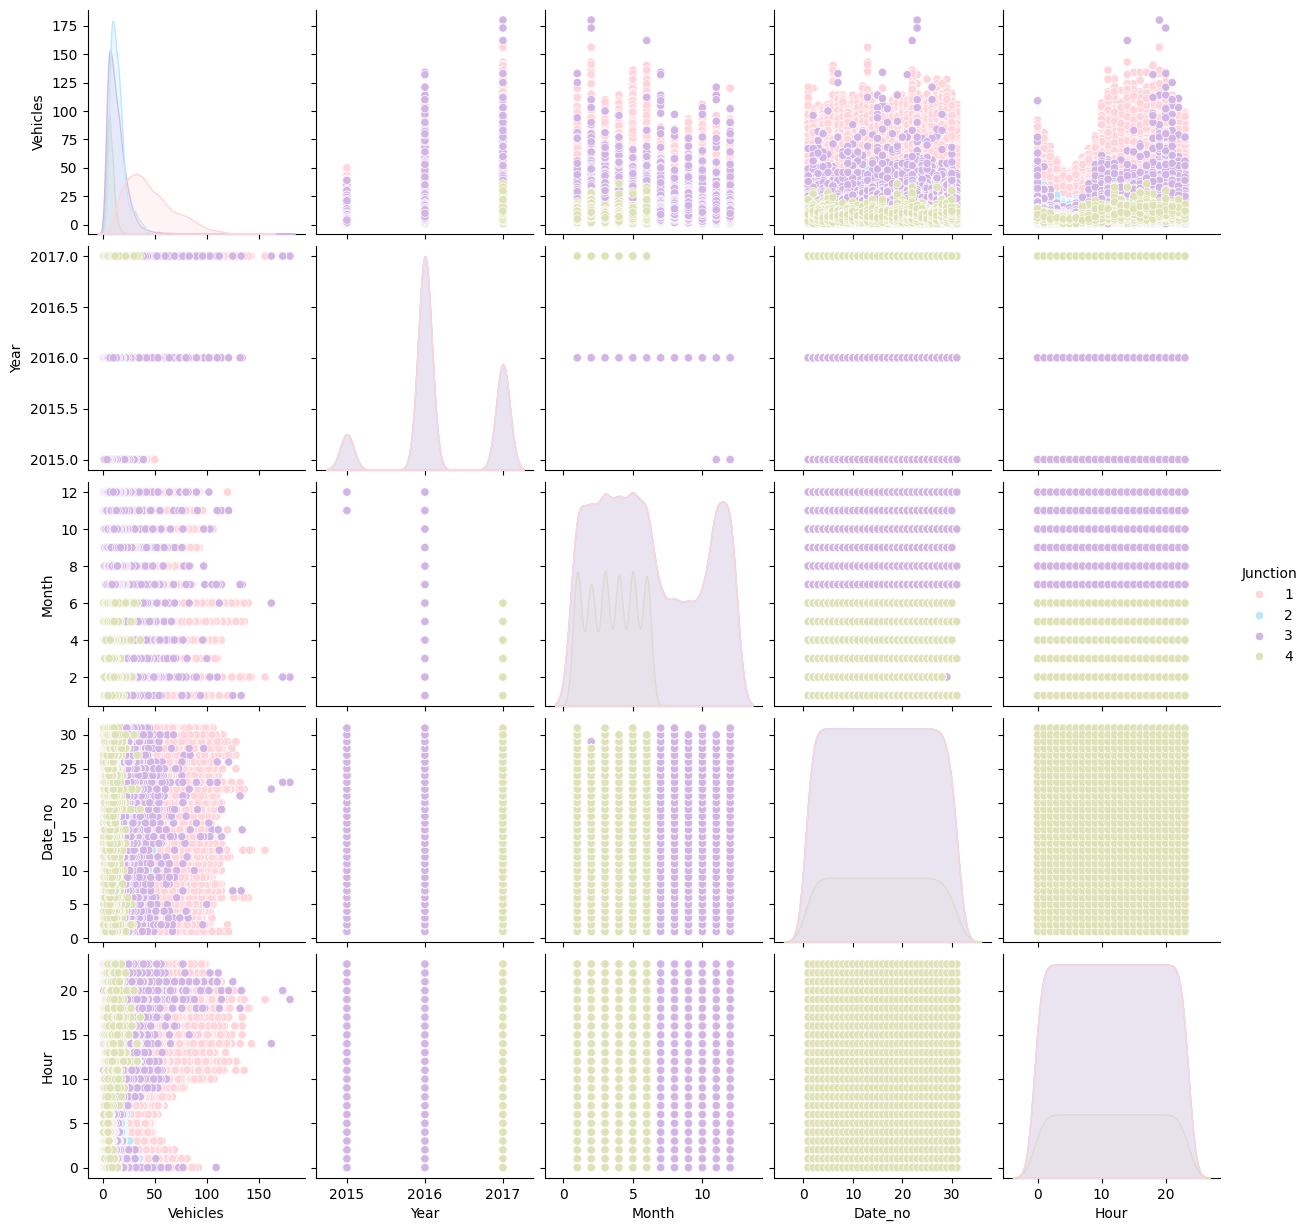

In [33]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

<h1>Exploratory Data Analysis</h1>

In [34]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

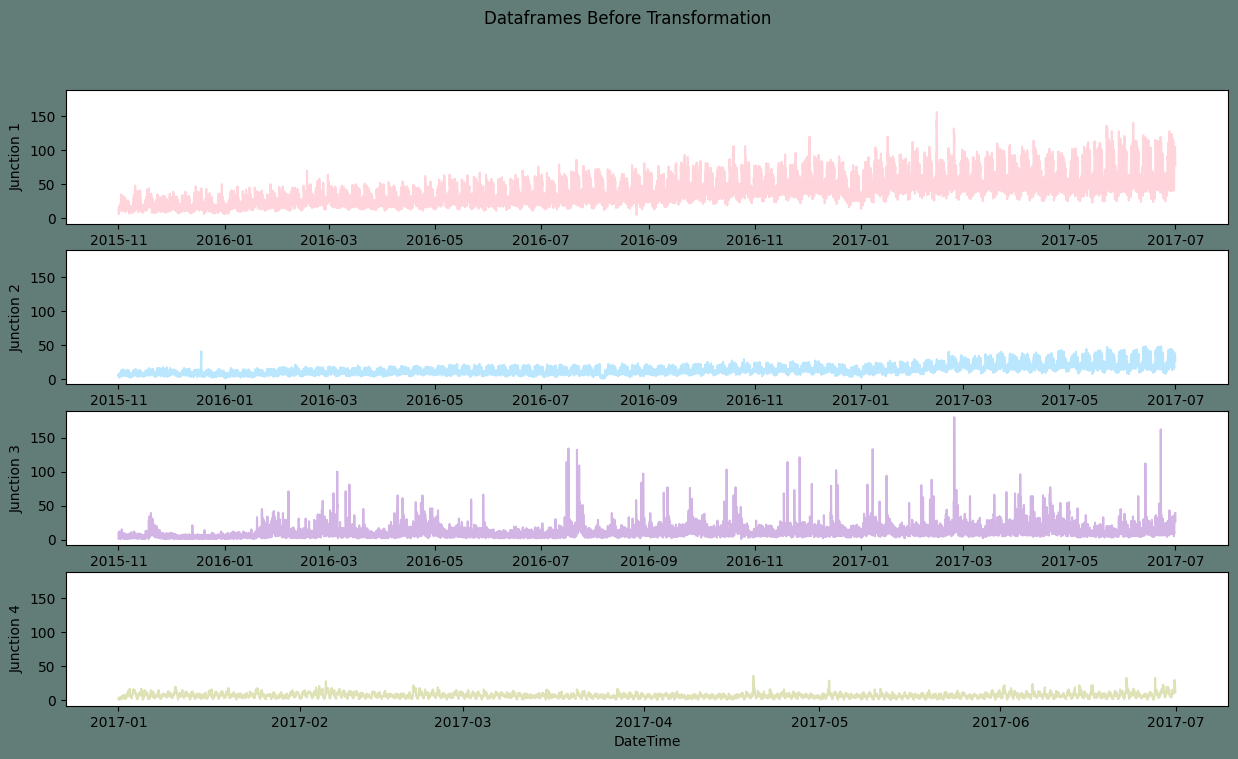

In [36]:
df_1 = df_J[[("Vehicles",1)]]
df_2 = df_J[[("Vehicles",2)]]
df_3 = df_J[[("Vehicles",3)]]
df_4 = df_J[[("Vehicles",4)]]
df_4 = df_4.dropna()

list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_plot(df_1,df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4,1,figsize(15,8),facecolor="#808080",sharey=True)
    fig.subplot(title)

    
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")

#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")    

Steps for Transforming:

Normalizing
Differencing

In [38]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [39]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

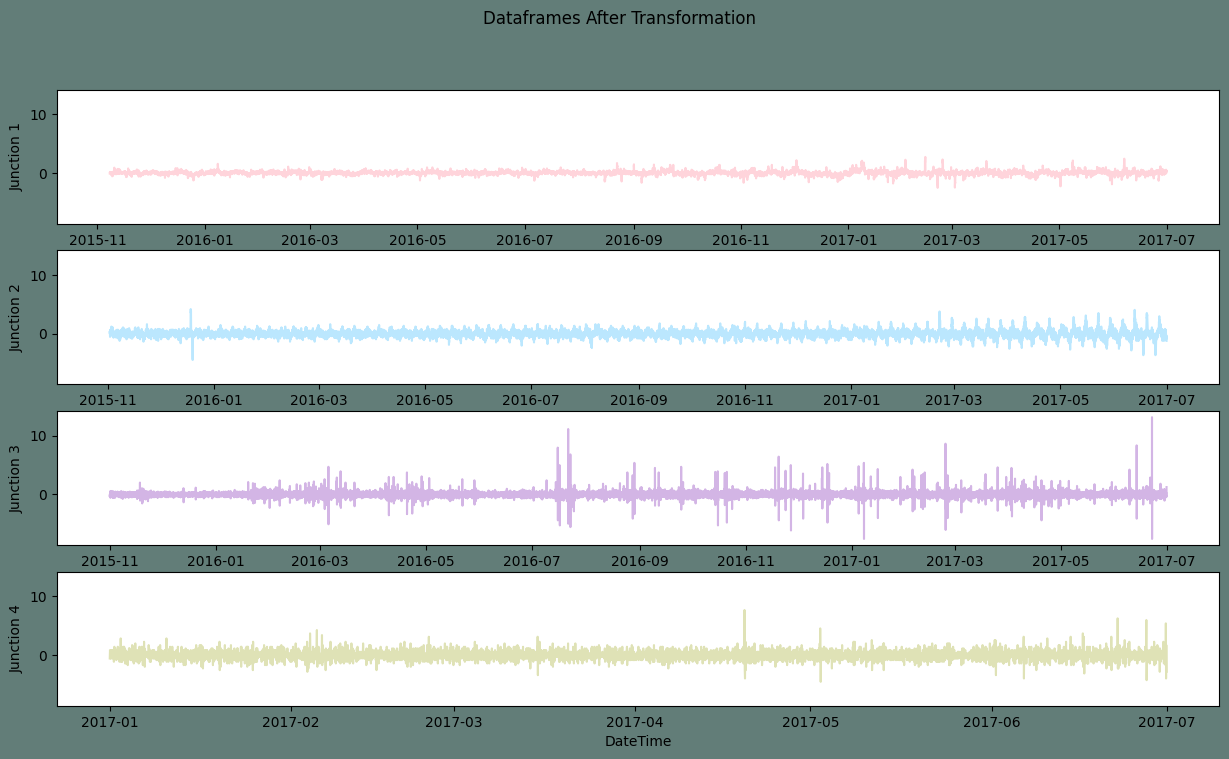

In [40]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


In [41]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415355
p-value: 4.798539876397885e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940073
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.0017599088326
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052184
p-value: 2.77878753259558e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [42]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

<h1>Model Building</h1>

In [43]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

<h1>Fitting The Model

</h1>

In [44]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 0.0838
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0686 
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0635 
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0611
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 0.0603
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0581 
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0604
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.0575 
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.0556
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.0585 
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0544 
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0550
Epoch 13/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.0554
Epoch 14/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.0546
Epoch 15/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 

The root mean squared error is 0.2466848032655561.


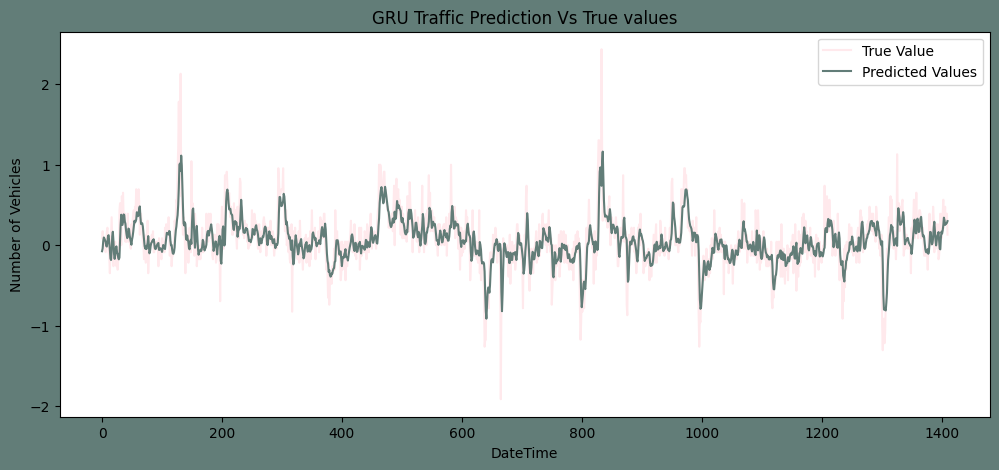

In [45]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [47]:
#Predictions For Second Junction
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - loss: 0.2629
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.2067 
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.2037
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.1962
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.1934
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - loss: 0.1891 
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.1885
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.1967
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1845
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 0.1976
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.1903 
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - loss: 0.1852 
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - loss: 0.1860
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - loss: 0.1847
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss

The root mean squared error is 0.5516555451697049.


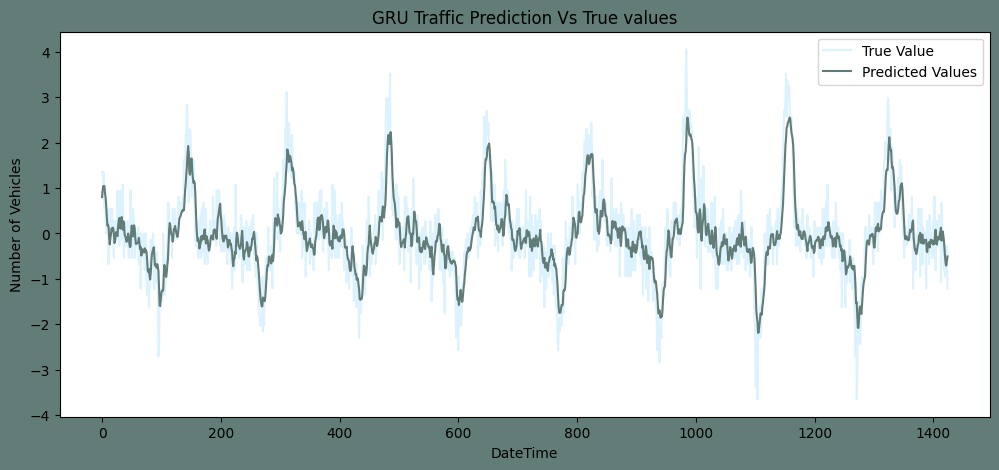

In [48]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [49]:
#Predictions For Third Junction
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 0.2821
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.3286
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.3227
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.3054
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.2617
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.3172 
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 96ms/step - loss: 0.3285
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 0.3175
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - loss: 0.3038
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.3114
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.2829
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.2637 
Epoch 13/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 0.2744
Epoch 14/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 0.2934 
Epoch 15/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 97ms/step - los

The root mean squared error is 0.6056566440704007.


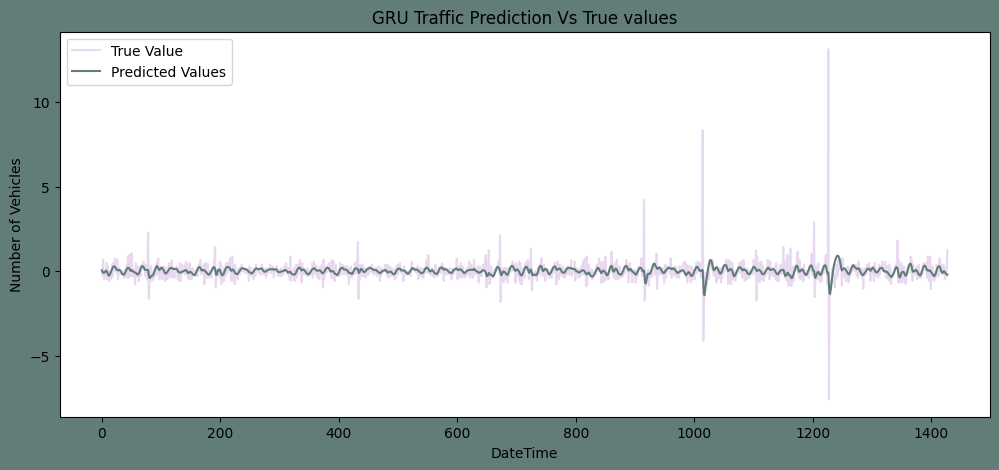

In [50]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [51]:
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.6683
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.6638
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.6870 
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.6646
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.6977
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.6934
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.6533
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.7141
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.6976
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 0.6772
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 0.7103
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.6812
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - loss: 0.6712
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.6839
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - lo

The root mean squared error is 1.015188127257181.


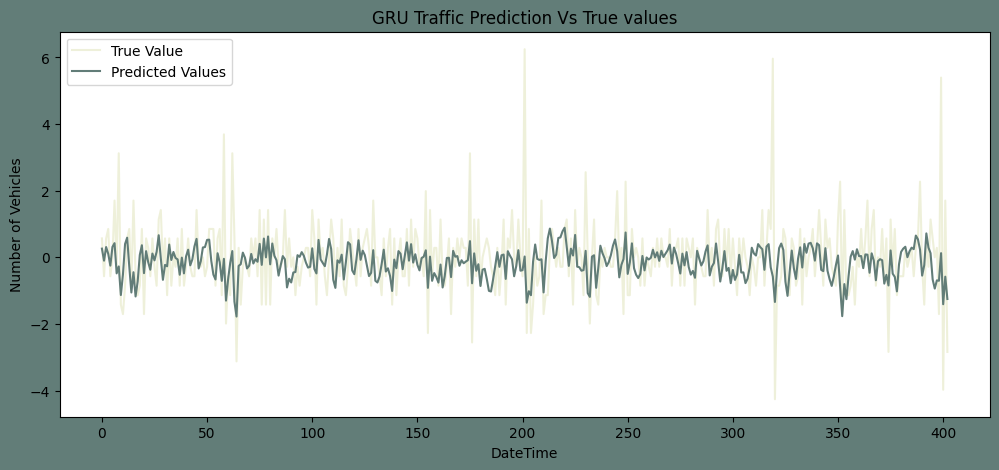

In [52]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

<h1>Inversing The Transformation Of Data</h1>

In [53]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

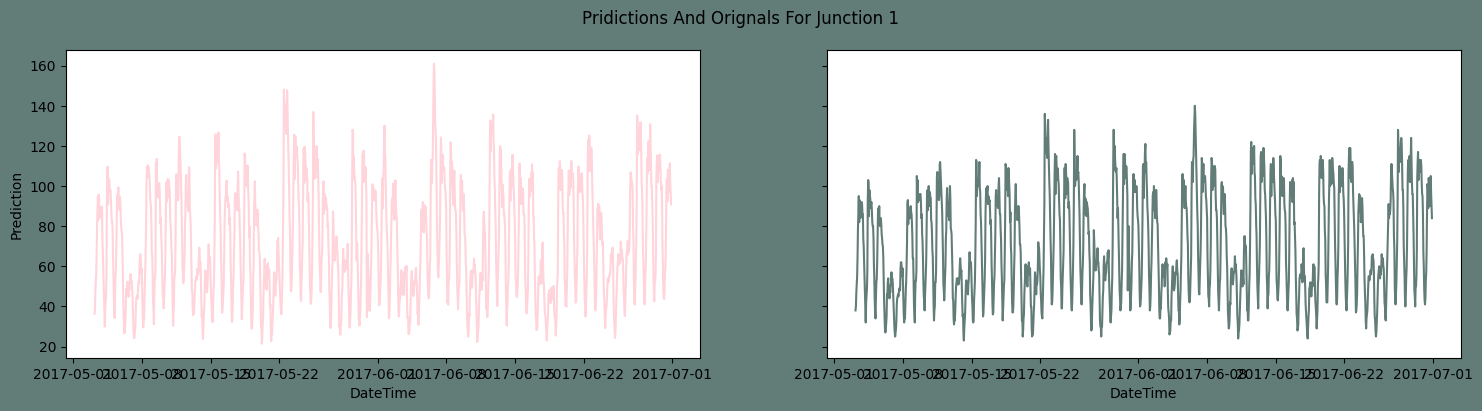

In [54]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

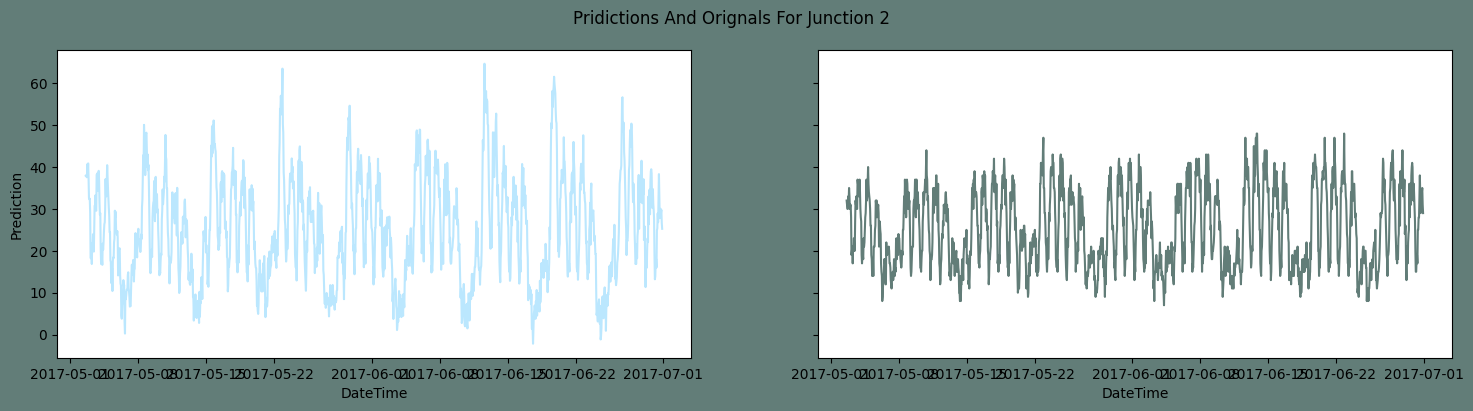

In [55]:
#Invert the differenced J2
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

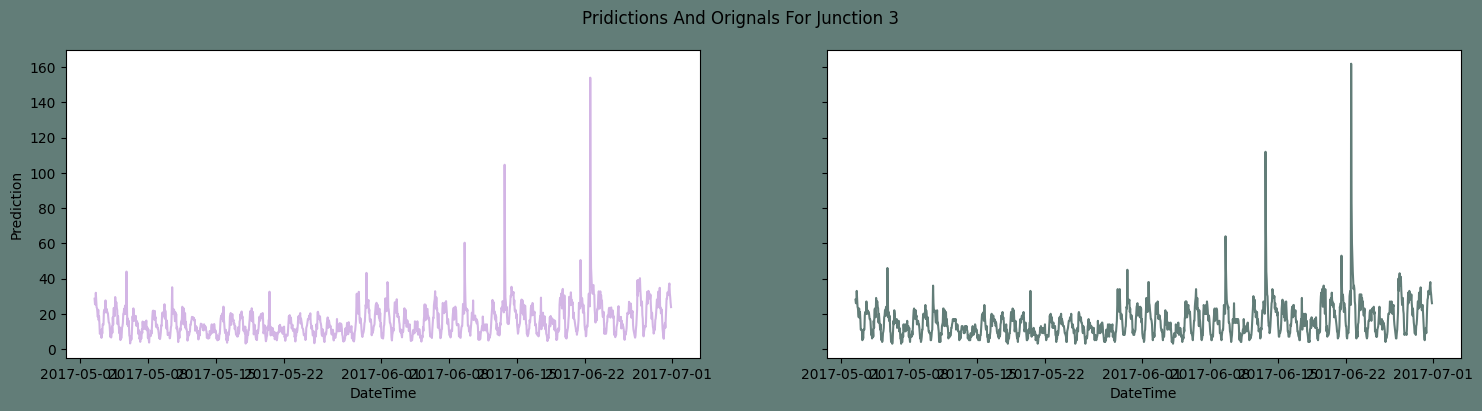

In [56]:
#Invert the differenced J3
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

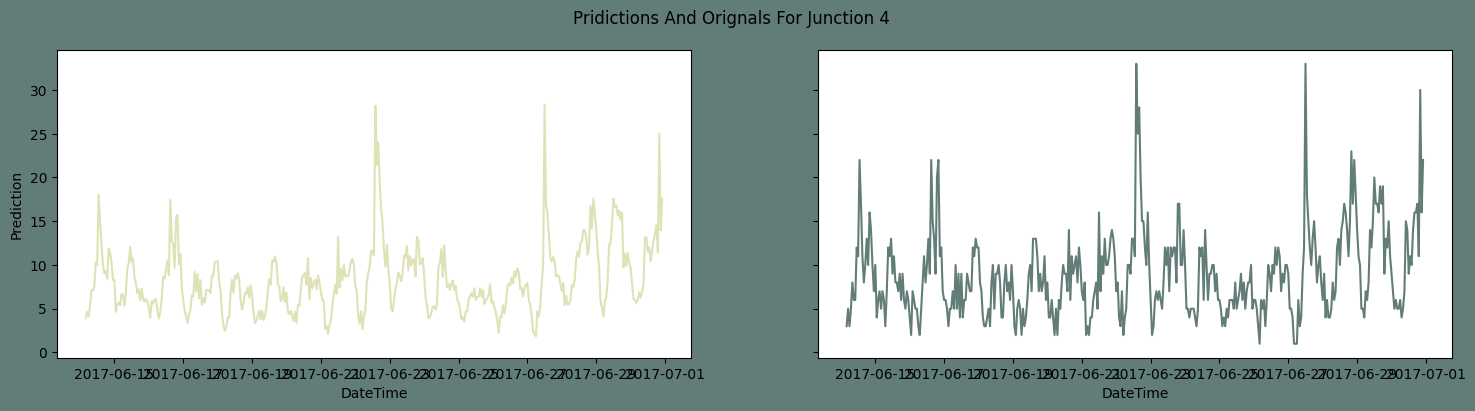

In [57]:
#Invert the differenced J4
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)